In [1]:
import fitIR
import fitIR.models as models
import fitIR.analyse as analyse
from astropy.cosmology import WMAP9 as cosmo
import jax
import numpy as np
import pylab as plt
import astropy.units as u
import scipy.integrate as integrate
%matplotlib inline

import jax.numpy as jnp
from jax import grad, jit, vmap, value_and_grad
from jax import random

# Generate key which is used to generate random numbers
key = random.PRNGKey(1)

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
from jax.experimental import stax

## Make training set by randomly sampling parameter space

In [3]:
totlir = np.arange(8,15,0.6)
redshift = np.arange(0.01,5.01,0.5)
temperature = np.arange(10,70,10)

In [4]:
def generate_samples(size=100):
    #get parameter values from uniform distribution
    LIR=np.random.uniform(low=8,high=15,size=size)
    redshift=np.random.uniform(low=0.01,high=6,size=size)
    temperature=np.random.uniform(low=10,high=70,size=size)
    #get standard deviation and mean for uniform dist
    LIR_sd=(15-8)/np.sqrt(12)
    LIR_mean=0.5*(15+8)
    
    red_sd=(6-0.01)/np.sqrt(12)
    red_mean=0.5*(0.01+6)
    
    temp_sd=(70-10)/np.sqrt(12)
    temp_mean=0.5*(70+10)
    return np.vstack((LIR,redshift,temperature)).T,np.vstack(((LIR-LIR_mean)/LIR_sd,(redshift-red_mean)/red_sd,(temperature-temp_mean)/temp_sd)).T

In [5]:
samp,samp_stand=generate_samples(1000)

In [6]:
samp.shape

(1000, 3)

In [7]:
import xidplus
from xidplus import filters
filter_=filters.FilterFile(file=xidplus.__path__[0]+'/../test_files/filters.res')

/Users/pdh21/anaconda3/envs/xidplus/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
W0104 11:48:46.144933 4605595072 logger.py:204] AstropyDeprecationWarning: block_reduce was moved to the astropy.nddata.blocks module.  Please update your import statement.


In [8]:
SPIRE_250=filter_.filters[215]
SPIRE_350=filter_.filters[216]
SPIRE_500=filter_.filters[217]
MIPS_24=filter_.filters[201]
PACS_100=filter_.filters[250]
PACS_160=filter_.filters[251]

bands=[SPIRE_250,SPIRE_350,SPIRE_500,MIPS_24,PACS_100,PACS_160]
eff_lam=[250.0,350.0,500.0,24.0, 100.0,160.0]

In [9]:
from scipy.interpolate import interp1d

def get_fluxes(samples):
    measured=np.empty_like(samples)
    val = np.linspace(np.log10(3E8/8E-6),np.log10(3E8/1E-3),1000)
    val = 10**val
    for i,s in enumerate(samples):
        z=s[1]
        prior = {}
        prior['z'] = s[1]
        prior['log10LIR'] = s[0]
        prior['T'] = s[2]
        prior['emissivity'] = 1.5



        source = models.greybody(prior)

        nu,lnu = source.generate_greybody(val,z)
        wave = 3E8/nu*1E6
        sed=interp1d(wave,lnu)
        dist = cosmo.luminosity_distance(z).to(u.cm).value

        for b in range(0,3):
            measured[i,b]=(1.0+z)*filters.fnu_filt(sed(bands[b].wavelength/1E4),
                                     3E8/(bands[b].wavelength/1E10),
                                     bands[b].transmission,
                                     3E8/(eff_lam[b]*1E-6),
                                     sed(eff_lam[b]))/(4*np.pi*dist**2)
    return measured/10**(-26)

In [10]:
measured=get_fluxes(samp)

## Use stax to create neural net

In [221]:
from jax.experimental import stax
from jax.experimental.stax import (BatchNorm, Conv, Dense, Flatten,
                                   Relu, LogSoftmax,LeakyRelu)
import time


In [63]:
batch_size=100
num_inputs=3
num_bands=3
#stax provides an intialising function and a function for doing a forward pass
init_fun,sed_emu = stax.serial(Dense(num_inputs),Relu,
                               Dense(20),Relu,
                              Dense(num_bands))


In [64]:
#function to get initial parameters of neural net
_, params = init_fun(key, (batch_size, num_inputs))

In [70]:
import torch
from torch.utils.data import Dataset, DataLoader

In [71]:
## class for sed using the torch dataset class
class sed_data(Dataset):
    
    def __init__(self,params,fluxes):
        self.X=params
        self.y=fluxes
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]

In [72]:
## generate random SED samples
samp_train,samp_stand_train=generate_samples(2000)
## Use Steve's code and xidplus filters to get fluxes
measured_train=get_fluxes(samp_train)
## use data in SED dataclass
ds = sed_data(samp_stand_train,measured_train)
## use torch DataLoader
train_loader = DataLoader(ds, batch_size=batch_size,)
## do same but for test set
samp_test,samp_stand_test=generate_samples(500)
measured_test=get_fluxes(samp_test)

ds = sed_data(samp_stand_test,measured_test)
test_loader = DataLoader(ds, batch_size=batch_size)

the update function computes teh gradient of the loss with respect to the parameters for a batch. We use predefined optimisers and choose Adan to be our optmisier

In [77]:
from jax.experimental import optimizers

@jit
def update(params, x, y, opt_state):
    """ Compute the gradient for a batch and update the parameters """
    value, grads = value_and_grad(loss)(params, x, y)
    opt_state = opt_update(0, grads, opt_state)
    return get_params(opt_state), opt_state, value




In [83]:
def accuracy(params, data_loader):
    """ Compute the accuracy for the SED emulator"""
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        x=jnp.asarray(data)
        predicted_flux=sed_emu(params, x)
        acc_total += jnp.sum((predicted_flux - jnp.asarray(target))**2)
    return acc_total/len(data_loader.dataset)

def loss(params, images, targets):
    preds = sed_emu(params, jnp.asarray(images))
    return jnp.sqrt(jnp.mean((jnp.asarray(targets) - preds)**2))

In [86]:
def run_greybody_training_loop(num_epochs, opt_state):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            x=jnp.asarray(data)
            y=jnp.asarray(target)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        print(len(params))
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                    train_acc, test_acc,))

    return train_loss, log_acc_train, log_acc_test

In [89]:
step_size = 1e-5
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
num_epochs = 20

train_loss, train_log, test_log = run_greybody_training_loop(num_epochs,
                                                          opt_state)


5
Epoch 1 | T: 0.08 | Train A: 1612982910976.000 | Test A: 202752896.000
5
Epoch 2 | T: 0.08 | Train A: 1612982910976.000 | Test A: 202753440.000
5
Epoch 3 | T: 0.07 | Train A: 1612982910976.000 | Test A: 202753904.000
5
Epoch 4 | T: 0.08 | Train A: 1612982910976.000 | Test A: 202754352.000
5
Epoch 5 | T: 0.08 | Train A: 1612982910976.000 | Test A: 202754864.000
5
Epoch 6 | T: 0.07 | Train A: 1612982910976.000 | Test A: 202755440.000
5
Epoch 7 | T: 0.08 | Train A: 1612982910976.000 | Test A: 202756128.000
5
Epoch 8 | T: 0.07 | Train A: 1612983042048.000 | Test A: 202756848.000
5
Epoch 9 | T: 0.06 | Train A: 1612983042048.000 | Test A: 202757568.000
5
Epoch 10 | T: 0.07 | Train A: 1612983042048.000 | Test A: 202758224.000
5
Epoch 11 | T: 0.07 | Train A: 1612983042048.000 | Test A: 202758912.000
5
Epoch 12 | T: 0.06 | Train A: 1612983042048.000 | Test A: 202759600.000
5
Epoch 13 | T: 0.07 | Train A: 1612983042048.000 | Test A: 202760272.000
5
Epoch 14 | T: 0.08 | Train A: 1612983042048.0

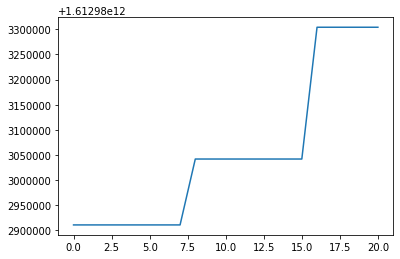

In [90]:
plt.plot(train_log)

## try simplifying

In [568]:

samp_train,samp_stand_train=generate_samples(10000)
measured_train=get_fluxes(samp_train)

ds = sed_data(samp_stand_train,measured_train)

train_loader = DataLoader(ds, batch_size=batch_size,)

samp_test,samp_stand_test=generate_samples(500)
measured_test=get_fluxes(samp_test)

num_inputs=3
num_bands=1
init_fun,sed_emu = stax.serial(Dense(num_inputs),Relu,
                              Dense(num_bands))
# Initialise the network with four inputs
out_shape, net_params = init_fun(key,(-1, 3))


ytrain=jnp.asarray(measured_train[:,0])
Xtrain=jnp.asarray(samp_stand_train)
ytest=jnp.asarray(measured_test[:,0])
Xtest=jnp.asarray(samp_stand_test)
def loss(params):
    predictions = sed_emu(params, Xtrain)
    return jnp.mean((ytrain - predictions)**2)
def loss_test(params):
    predictions = sed_emu(params, Xtest)
    return jnp.mean((ytest - predictions)**2)


opt_init, opt_update, get_params = optimizers.adam(0.01)

@jit
def step(i, opt_state):
    # Parameters for the optimisation algorithm
    params = get_params(opt_state)
    # Gradient of the loss function
    g = grad(loss)(params)
    # Update step
    return opt_update(i, g, opt_state),loss(params),loss_test(params)
# Optimiser initialisation
opt_state = opt_init(net_params)

all_loss=[]
all_loss_test=[]
for i in range(50000):
    # Train step
    opt_state,loss_iter,loss_test_iter = step(i, opt_state)
    all_loss.append(loss_iter)
    all_loss_test.append(loss_test_iter)

# Final parameters after training
net_params = get_params(opt_state)

KeyboardInterrupt: 

In [569]:
sed_emu(net_params,jnp.asarray(samp_stand_test))

DeviceArray([[ 1.15468442e+00],
             [-9.58508172e-04],
             [ 2.54261899e+00],
             [ 3.60584527e-01],
             [-9.58508172e-04],
             [ 2.07726550e+00],
             [ 9.92553949e-01],
             [-9.58508172e-04],
             [ 2.42397380e+00],
             [ 2.25675121e-01],
             [-9.58508172e-04],
             [ 1.56079197e+00],
             [-9.58508172e-04],
             [ 2.42112923e+00],
             [-4.59634215e-02],
             [-2.07831711e-02],
             [-3.63815483e-03],
             [-4.87463474e-02],
             [ 1.26780784e-02],
             [ 2.65504003e+00],
             [ 9.33449447e-01],
             [ 3.37957054e-01],
             [-9.58508172e-04],
             [-9.58508172e-04],
             [-9.58508172e-04],
             [-9.58508172e-04],
             [ 7.08476484e-01],
             [-9.58508172e-04],
             [ 6.70050085e-01],
             [-9.58508172e-04],
             [-9.58508172e-04],
        

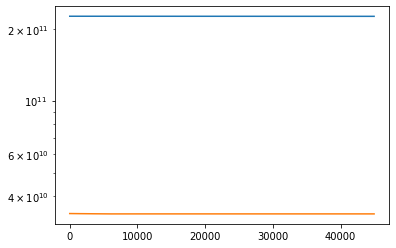

In [570]:
plt.semilogy(all_loss)
plt.plot(all_loss_test)

### Try simple linear regression with Stax
To get to the bottom of Stax, I will use to predict $y=xcos(x)+sin(2x)$

In [301]:
x=np.arange(0,20,0.1)
def simple_func(x):
    y=np.sin(x)+0.2*np.random.normal(size=x.shape)
    return y

Text(0, 0.5, 'y')

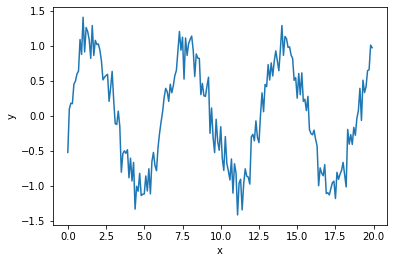

In [302]:
plt.plot(x,simple_func(x))
plt.xlabel('x')
plt.ylabel('y')

In [343]:
batch_size=40
num_inputs=1
num_bands=1
#stax provides an intialising function and a function for doing a forward pass
init_fun,simple_emu = stax.serial(Dense(num_inputs),LeakyRelu,
                                  Dense(200),LeakyRelu,
                              Dense(num_bands))


In [344]:
#function to get initial parameters of neural net
_, params = init_fun(key, (batch_size, num_inputs))

## class for sed using the torch dataset class
class simple_data(Dataset):
    
    def __init__(self,x,y):
        self.X=x
        self.y=y
    def __len__(self):
        return len(self.X)
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]

In [345]:
train_x=np.random.uniform(-10,10,(4000,1))
train_y=simple_func(train_x)
test_x=np.random.uniform(-10,10,(1000,1))
test_y=simple_func(test_x)

In [346]:

## use data in Simple dataclass
ds = simple_data(train_x,train_y)
## use torch DataLoader
train_loader = DataLoader(ds, batch_size=batch_size,)
## do same but for test set

ds = sed_data(test_x,test_y)
test_loader = DataLoader(ds, batch_size=batch_size)

In [347]:
def accuracy(params, data_loader):
    """ Compute the accuracy for the SED emulator"""
    acc_total = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        x=jnp.asarray(data)
        predicted=simple_emu(params, x)
        acc_total += jnp.sum((predicted - jnp.asarray(target))**2)
    return acc_total/len(data_loader.dataset)

def loss(params, images, targets):
    preds = simple_emu(params, jnp.asarray(images))
    return jnp.mean((jnp.asarray(targets) - preds)**2)

In [348]:
def run_simple_training_loop(num_epochs, opt_state):
    """ Implements a learning loop over epochs. """
    # Initialize placeholder for loggin
    log_acc_train, log_acc_test, train_loss = [], [], []

    # Get the initial set of parameters
    params = get_params(opt_state)

    # Get initial accuracy after random init
    train_acc = accuracy(params, train_loader)
    test_acc = accuracy(params, test_loader)
    log_acc_train.append(train_acc)
    log_acc_test.append(test_acc)

    # Loop over the training epochs
    for epoch in range(num_epochs):
        start_time = time.time()
        for batch_idx, (data, target) in enumerate(train_loader):
            x=jnp.asarray(data)
            y=jnp.asarray(target)
            params, opt_state, loss = update(params, x, y, opt_state)
            train_loss.append(loss)

        epoch_time = time.time() - start_time
        train_acc = accuracy(params, train_loader)
        test_acc = accuracy(params, test_loader)
        log_acc_train.append(train_acc)
        log_acc_test.append(test_acc)
        if epoch%50==0:
            print("Epoch {} | T: {:0.2f} | Train A: {:0.3f} | Test A: {:0.3f}".format(epoch+1, epoch_time,
                                                                        train_acc, test_acc,))

    return train_loss, log_acc_train, log_acc_test,params

In [349]:
#function to get initial parameters of neural net
_, params = init_fun(key, (batch_size, num_inputs))
step_size = 0.05
opt_init, opt_update, get_params = optimizers.adam(step_size)
opt_state = opt_init(params)
num_epochs = 500
my_images = []
train_loss, train_log, test_log,params = run_simple_training_loop(num_epochs,
                                                          opt_state)


[(Traced<ShapedArray(float32[1,1])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=0/1)>), (), (Traced<ShapedArray(float32[1,200])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[200])>with<DynamicJaxprTrace(level=0/1)>), (), (Traced<ShapedArray(float32[200,1])>with<DynamicJaxprTrace(level=0/1)>, Traced<ShapedArray(float32[1])>with<DynamicJaxprTrace(level=0/1)>)]
Epoch 1 | T: 0.87 | Train A: 0.527 | Test A: 0.509
Epoch 51 | T: 0.21 | Train A: 0.508 | Test A: 0.498
Epoch 101 | T: 0.25 | Train A: 0.502 | Test A: 0.500
Epoch 151 | T: 0.25 | Train A: 0.503 | Test A: 0.504
Epoch 201 | T: 0.18 | Train A: 0.503 | Test A: 0.500
Epoch 251 | T: 0.27 | Train A: 0.503 | Test A: 0.500
Epoch 301 | T: 0.22 | Train A: 0.503 | Test A: 0.501
Epoch 351 | T: 0.27 | Train A: 0.503 | Test A: 0.500
Epoch 401 | T: 0.22 | Train A: 0.504 | Test A: 0.501
Epoch 451 | T: 0.23 | Train A: 0.503 | Test A: 0.500


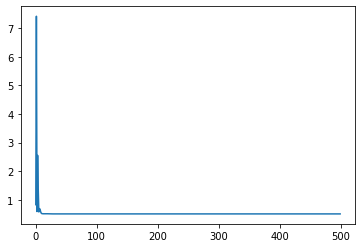

In [339]:
plt.plot(train_loss)

In [340]:

predicted=simple_emu(params, test_x)

In [341]:
print(test_y.shape)


(1000, 1)


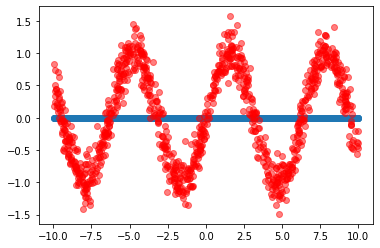

In [342]:
plt.plot(test_x,predicted,'o')
plt.plot(test_x,test_y,'ro',alpha=0.5)

### Retry with [Eric Jang's tutorial on meta learning](https://blog.evjang.com/2019/02/maml-jax.html)

In [350]:
import jax.numpy as np
from jax import grad

In [351]:
f = lambda x : np.exp(x)
g = lambda x : np.square(x)
print(grad(f)(1.)) # = e^{1}
print(grad(grad(f))(1.))
print(grad(grad(grad(f)))(1.))

print(grad(g)(2.)) # 2x = 4
print(grad(grad(g))(2.)) # x = 2
print(grad(grad(grad(g)))(2.)) # x = 0


2.7182817
2.7182817
2.7182817
4.0
2.0
0.0


In [353]:
from jax import vmap # for auto-vectorizing functions
from functools import partial # for use with vmap
from jax import jit # for compiling functions for speedup
from jax.experimental import stax # neural network library
from jax.experimental.stax import Conv, Dense, MaxPool, Relu, Flatten, LogSoftmax # neural network layers
import matplotlib.pyplot as plt # visualization

In [355]:
# Use stax to set up network initialization and evaluation functions
net_init, net_apply = stax.serial(
    Dense(40), Relu,
    Dense(40), Relu,
    Dense(1)
)
in_shape = (-1, 1,)
out_shape, net_params = net_init(key,in_shape)

In [356]:
def loss(params, inputs, targets):
    # Computes average loss for the batch
    predictions = net_apply(params, inputs)
    return np.mean((targets - predictions)**2)


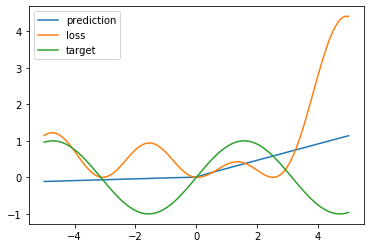

In [357]:
# batch the inference across K=100
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

In [358]:
import numpy as onp
from jax.experimental import optimizers
from jax.tree_util import tree_multimap  # Element-wise manipulation of collections of numpy arrays 

In [364]:
opt_init, opt_update,get_params = optimizers.adam(step_size=1e-2)
opt_state = opt_init(net_params)
# Define a compiled update step
@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(loss)(p, x1, y1)
    loss_tmp=loss(p,x1,y1)
    return opt_update(i, g, opt_state),loss_tmp
loss_all=[]
for i in range(100):
    opt_state,loss_tmp = step(i, opt_state, xrange_inputs, targets)
    loss_all.append(loss_tmp)
net_params = get_params(opt_state)

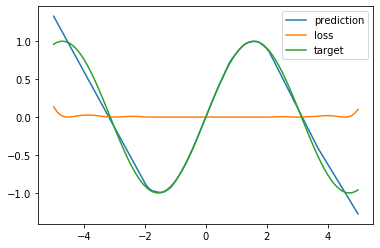

In [365]:
#batch the inference across K=100
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()

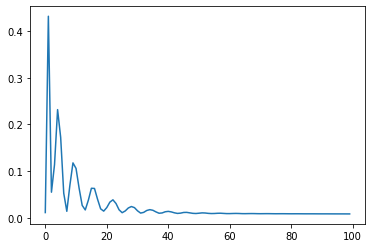

In [366]:
plt.plot(loss_all)

In [ ]:
def maml_loss(p, x1, y1, x2, y2):
    p2 = inner_update(p, x1, y1)
    return loss(p2, x2, y2)

In [ ]:
# vmapped version of maml loss.
# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = vmap(partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return np.mean(task_losses)

In [372]:
def batch_loss(p,x_b,y_b):
    loss_b=vmap(partial(loss,p))(x_b,y_b)
    return np.mean(loss_b)

In [373]:
import numpy as onp
# batch the inference across K=100
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)

def sample_batch(outer_batch_size,inner_batch_size):
    def get_batch():
        xs, ys = [], []
        A=1
        phase=0
        for i in range(0,outer_batch_size):
            x = onp.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * onp.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    return x1, y1
    
    
    

In [377]:
opt_init, opt_update, get_params= optimizers.adam(step_size=1e-3)
out_shape, net_params = net_init(key,in_shape)
opt_state = opt_init(net_params)

@jit
def step(i, opt_state, x1, y1):
    p = get_params(opt_state)
    g = grad(batch_loss)(p, x1, y1)
    loss_tmp=batch_loss(p,x1,y1)
    return opt_update(i, g, opt_state),loss_tmp

np_batched_loss_1 = []
K=20
for i in range(20000):
    x1_b, y1_b = sample_batch(1, K)
    opt_state, l = step(i, opt_state, x1_b, y1_b)
    np_batched_loss_1.append(l)
    if i % 1000 == 0:
        print(i)
net_params = get_params(opt_state)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000


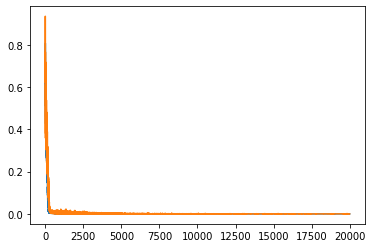

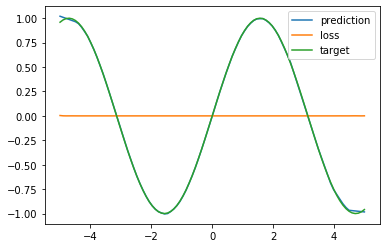

In [380]:
#batch the inference across K=100
xrange_inputs = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(xrange_inputs)
predictions = vmap(partial(net_apply, net_params))(xrange_inputs)
losses = vmap(partial(loss, net_params))(xrange_inputs, targets) # per-input loss
plt.plot(xrange_inputs, predictions, label='prediction')
plt.plot(xrange_inputs, losses, label='loss')
plt.plot(xrange_inputs, targets, label='target')
plt.legend()